## Exploring MODIS Data for Frontal Eddies

* Download a bunch of chl-a and SST data from MODIS, I guess level 3 is good enough but need to double check
    * should also download some GOES SST data and think about altimetry data
    * also need bathymetry dataset for masking to outer shelf
*  When I sum up the monthly chla what are the hotspots across the Atlantic Ocean and SAB region?
*  Make a figure that is a transect from the coast out to the center of the Sargasso sea that shows the seasonality of the chla like a surface plot of something.
    * some variations on this, a transect out to the sargasso sea on x and on the y show chl-a across time
        * also do this with SST
* Go through a bunch of chl-a images just to get a good idea for where the chl-a front is from coast to outer shelf and then again to open ocean
    * make a front frequency map based on the sharpest gradient
* Just generally explore some frontal eddies in SST, chl-a, and altimetry 
    * Need to get an idea for whether the productivity is generally inside or outside of the frontal eddy
    *  Key to remember that if the eddy exists in a gradient (which 99% it does) that it will stir that gradient and produce anomalies just via stirring like the typical dipole seen in eddies
    *  Should definitely look into eddy centric coordinates for frontal eddies
    *  Put together a time series of an eddy from GOES SST data and maybe from the RGB bands
* Run an EOF analysis on the whole area to get a better idea for spatial patterns
*  What dominates variability of phytoplankton production and diversity in the South Atlantic Bight north of the Charleston Bump to Cape Hatteras? Assuming it is frontal eddies or other GS driven upwelling. How much of this is on the submesoscale?
    *  It could also be wind, seasonality, hurricanes, etc.
    *  How far offshore do I need to go to avoid terrestrial inputs being significant?
    *  Also just quantifying the basic spatial and temporal variability as in Doney et al 2003 and showing which regions have the highest variability using semi-variograms and std dev.
*  Further explore the features with major impact on variability (I assume it is a frontal eddy) using satellites, Argo floats, and gliders to seeing if it is captured in models as appropriate biological production for frontal eddies, then seeing what is happening on a submesoscale level.
*  Do a scaling analysis in this area and it will be much more informative once I have a general idea of what dominates variability.
    *  Which I might be able to understand just from papers, but also want to demonstrate.
    *  This scaling analysis could also be from a single point and I could see if the variability is roughly biweekly and seasonal as would be expected from frontal eddies and phenology.
*  How many frontal eddies actually occur?
    *  Could we constrain the impact of frontal eddies from high res observations and then find out how many there actually are via SAR?
*  Have any BGC-Argo floats been entrained in a frontal eddy?
*  Can I get some estimate on frontal eddy impact on upwelling directly off Cape Hatteras via the ADCP data from Mike/Trip?
    *  Is there still upwelling going on as it is sheared apart?
        *  It certainly appears so and they aren’t necessarily sheared apart before Cape Hatteras based on the literature.
*  Biogeography and Clustering
    *  Need to try the EOF method to look at variability across regions. Should be easy in python using EOF library.
    *   

In [1]:
import numpy as np
import xarray as xr
import os.path as op
from matplotlib import colors, ticker
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import date, timedelta, datetime
import cartopy.crs as crs
import hvplot.xarray

#### Download Data from OpenDAP

In [87]:
# example full url is 'https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L3SMI/2003/103/A2003103.L3m_DAY_CHL_chlor_a_4km.nc'

base_url = 'https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L3SMI/'

start_date = date(2018, 7, 1)
current_date = date(2018, 7, 1)
end_date = date(2018, 7, 30)
delta = timedelta(days=1)

while current_date <= end_date:
    url = base_url + current_date.strftime("%Y") + "/" + current_date.strftime("%j") + "/A" + \
    current_date.strftime("%Y") + current_date.strftime("%j") + ".L3m_DAY_CHL_chlor_a_4km.nc"
    
    
    ds = xr.open_dataset(url)
    ds_geo_subset = ds.sel( lat=slice(42, 20), lon=slice(-85,-65))
    print(ds_geo_subset.chlor_a.size)
    expanded_ds = ds_geo_subset.expand_dims("time").assign_coords(time=("time", [np.datetime64(current_date)]))
    if current_date == start_date:
        expanded_ds.to_zarr('chla_zarr_summer')
    else:
        expanded_ds.to_zarr('chla_zarr_summer', append_dim='time')
    print('finished: ', url)
    current_date += delta

253440
finished:  https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L3SMI/2018/182/A2018182.L3m_DAY_CHL_chlor_a_4km.nc
253440
finished:  https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L3SMI/2018/183/A2018183.L3m_DAY_CHL_chlor_a_4km.nc
253440
finished:  https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L3SMI/2018/184/A2018184.L3m_DAY_CHL_chlor_a_4km.nc
253440
finished:  https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L3SMI/2018/185/A2018185.L3m_DAY_CHL_chlor_a_4km.nc
253440
finished:  https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L3SMI/2018/186/A2018186.L3m_DAY_CHL_chlor_a_4km.nc
253440
finished:  https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L3SMI/2018/187/A2018187.L3m_DAY_CHL_chlor_a_4km.nc
253440
finished:  https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L3SMI/2018/188/A2018188.L3m_DAY_CHL_chlor_a_4km.nc
253440
finished:  https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L3SMI/2018/189/A2018189.L3m_DAY_CHL_chlor_a

In [99]:
# example full url is 'https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L3SMI/2003/103/A2003103.L3m_DAY_CHL_chlor_a_4km.nc'

base_url = 'https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L3SMI/'

start_date = date(2018, 1, 1)
current_date = date(2018, 1, 1)
end_date = date(2018, 12, 25)
delta = timedelta(days=8)

while current_date <= end_date:
    end_period = current_date + timedelta(days=7)
    
    url = base_url + current_date.strftime("%Y") + "/" + current_date.strftime("%j") + "/A" + \
    current_date.strftime("%Y") + current_date.strftime("%j") + end_period.strftime("%Y") + \
    end_period.strftime("%j") + ".L3m_8D_CHL_chlor_a_4km.nc"
    
    
    ds = xr.open_dataset(url)
    ds_geo_subset = ds.sel( lat=slice(42, 20), lon=slice(-85,-65))
    print(ds_geo_subset.chlor_a.size)
    expanded_ds = ds_geo_subset.expand_dims("time").assign_coords(time=("time", [np.datetime64(current_date)]))
    if current_date == start_date:
        expanded_ds.to_zarr('chla_zarr_8D')
    else:
        expanded_ds.to_zarr('chla_zarr_8D', append_dim='time')
    print('finished: ', url)
    current_date += delta

253440
finished:  https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L3SMI/2018/001/A20180012018008.L3m_8D_CHL_chlor_a_4km.nc
253440
finished:  https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L3SMI/2018/009/A20180092018016.L3m_8D_CHL_chlor_a_4km.nc
253440
finished:  https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L3SMI/2018/017/A20180172018024.L3m_8D_CHL_chlor_a_4km.nc
253440
finished:  https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L3SMI/2018/025/A20180252018032.L3m_8D_CHL_chlor_a_4km.nc
253440
finished:  https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L3SMI/2018/033/A20180332018040.L3m_8D_CHL_chlor_a_4km.nc
253440
finished:  https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L3SMI/2018/041/A20180412018048.L3m_8D_CHL_chlor_a_4km.nc
253440
finished:  https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L3SMI/2018/049/A20180492018056.L3m_8D_CHL_chlor_a_4km.nc
253440
finished:  https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L

OSError: [Errno -90] NetCDF: file not found: b'https://oceandata.sci.gsfc.nasa.gov/opendap/hyrax/MODISA/L3SMI/2018/361/A20183612019003.L3m_8D_CHL_chlor_a_4km.nc'

#### Open the Data

In [100]:
chla_ds = xr.open_zarr('chla_zarr_8D')

In [101]:
proj = crs.Orthographic(-90, 30)

chla_ds.chlor_a.hvplot.quadmesh(
    'lon', 'lat', projection=proj, project=True,
    cmap='jet', dynamic=True, coastline=True, 
    frame_width=500, logz=True, clim=(0.01,2), datashade=True)

:DynamicMap   [time]
   :Overlay
      .RGB.I       :RGB   [lon,lat]   (R,G,B,A)
      .Coastline.I :Feature   [Longitude,Latitude]

In [92]:
# Subset to area from Charleston to Cape Hatteras and find examples that are >70% nonnan

In [ ]:
np.count_nonzero(~np.isnan(data))

In [ ]:
### Calculate Monthly Averages and then sum up chl-a through time ignoring nans

In [103]:
chla_ds_month = chla_ds.resample(time='1M').mean()

In [106]:
proj = crs.Orthographic(-90, 30)

chla_ds_month.chlor_a.hvplot.quadmesh(
    'lon', 'lat', projection=proj, project=True,
    cmap='jet', dynamic=True, coastline=True, 
    frame_width=500, logz=True, clim=(0.01,2), datashade=True)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


:DynamicMap   [time]
   :Overlay
      .RGB.I       :RGB   [lon,lat]   (R,G,B,A)
      .Coastline.I :Feature   [Longitude,Latitude]

In [114]:
chla_ds_month.chlor_a.sum(dim='time', skipna=False).hvplot.quadmesh(
    'lon', 'lat', projection=proj, project=True,
    cmap='jet', dynamic=True, coastline=True, 
    frame_width=500, logz=True, clim=(0.01,20), datashade=True)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


:DynamicMap   []
   :Overlay
      .RGB.I       :RGB   [lon,lat]   (R,G,B,A)
      .Coastline.I :Feature   [Longitude,Latitude]

In [142]:
### Run a couple transects out across the ocean off the coastline and plot x as longitude and y as chla

chla_lat_subset = chla_ds_month.sel(lat=slice(33,32.5))

chla_lat_subset.hvplot.quadmesh(
    'lon', 'lat', projection=proj, project=True,
    cmap='jet', dynamic=True, coastline=True, 
    frame_width=500, logz=True, clim=(0.01,20), datashade=False)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


:DynamicMap   [time]
   :Overlay
      .QuadMesh.I  :QuadMesh   [lon,lat]   (chlor_a)
      .Coastline.I :Feature   [Longitude,Latitude]

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


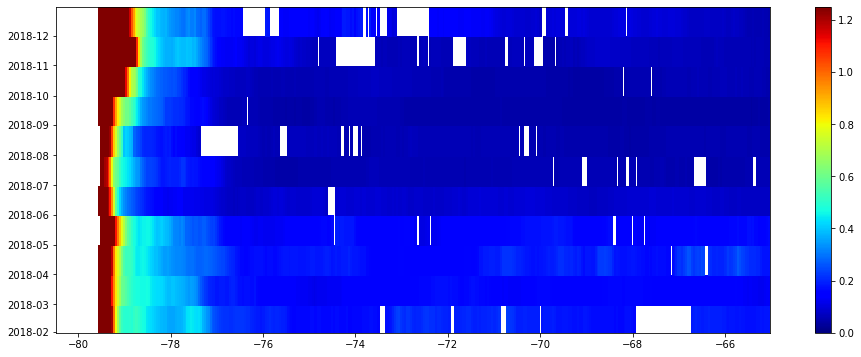

In [145]:
### Run a couple transects out across the ocean off the coastline and plot x as longitude and y as chla

chla_lat_mean = chla_lat_subset.mean(dim='lat', skipna=False).sel(lon=slice(-80.5,-64))
fig,ax = plt.subplots(figsize=(16,6))
im = ax.pcolor(chla_lat_mean.lon, chla_lat_mean.time, chla_lat_mean.chlor_a, vmax=1.25, vmin=0, cmap='jet')
fig.colorbar(im)